### Overview
This notebook details the data acquisition, data cleaning and feature engineering.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
from __future__ import division
from difflib import get_close_matches
from datetime import date
import datetime
from datetime import datetime
import seaborn as sns
import pickle
from nltk.corpus import words

Data were collected from City of Austin Open Data (https://data.austintexas.gov/browse?q=animal&sortBy=relevance&utf8=%E2%9C%93), and encompass animal shelter intakes from October 2013 to July 2016, and outcomes from October 2013 to February 2016.

In [45]:
# read in outcome and intake data
outcome = pd.read_csv("data/austin_outcomes.csv")
intake = pd.read_csv("data/austin_intakes.csv")

In [46]:
len(outcome)

43870

In [47]:
# subset to dogs only
outcome = outcome[outcome["Animal Type"]=="Dog"]
intake = intake[intake["Animal Type"]=="Dog"]
# convert date to datetime
intake["DateTime"] = intake["DateTime"].apply(lambda x: pd.to_datetime(x).date())
outcome["DateTime"] = outcome["DateTime"].apply(lambda x: pd.to_datetime(x).date())
outcome.drop("MonthYear", axis=1, inplace=True)
intake.drop("MonthYear", axis=1, inplace=True)
# drop duplicated rows
outcome = outcome.drop_duplicates()
intake = intake.drop_duplicates()

In [48]:
# drop rows where animal ID and event date are the same - there are some duplicate entries
outcome = outcome.drop_duplicates(["Animal ID","DateTime"])
intake = intake.drop_duplicates(["Animal ID","DateTime"])


Since some dogs appear in the data multiple times (i.e. they are taken into the shelter, and leave the shelter, more than once), in order to match each dog's intake to the correct outcome, the data can't simply be merged on dog ID.

In [49]:
# sort dfs by date
outcome = outcome.sort_values(["DateTime","Animal ID"])
intake = intake.sort_values(["DateTime","Animal ID"])

# match up intake dates with potential outcome dates for each animal and intake event.
animal_list = []
in_list = []
out_list = []
for i,j in zip(intake["Animal ID"],intake["DateTime"]):
    animal_list.append(i)
    in_list.append(j)
    out_dates = list(outcome[outcome["Animal ID"]==i]["DateTime"])
    out_list.append(out_dates)

In [50]:
# create df
date_df = pd.DataFrame(zip(animal_list,in_list,out_list), columns = ["ID","in_date","out_date"])
# choose correct outcome date for each animal and intake (i.e. the earliest outcome date that is after intake)
def correct_date(row):
    for i in row["out_date"]:
        if i>=row["in_date"]:
            return i
            break
    else:
        return np.nan
date_df["correct_out"] = date_df.apply(correct_date, axis=1)
date_df.drop("out_date", axis=1, inplace=True)
date_df.columns = ["ID","in_date","out_date"]

In [51]:
date_df.head()

,ID,in_date,out_date
0,A477934,2013-10-01,2013-10-02
1,A521520,2013-10-01,2013-10-01
2,A634503,2013-10-01,2013-10-02
3,A636021,2013-10-01,2013-10-12
4,A639030,2013-10-01,2013-10-02


In [52]:
# merged with intake data
joined = pd.merge(date_df, intake, left_on = ["ID","in_date"], right_on = ["Animal ID","DateTime"])
# merge with outcome data
joined = pd.merge(joined, outcome, how = "left", left_on = ["ID","out_date"], right_on = ["Animal ID","DateTime"])
# drop extra date columns
joined.drop(["DateTime_x","DateTime_y"], axis=1, inplace=True)
# convert date columns to datetime
joined["in_date"] = joined["in_date"].apply(lambda x: pd.to_datetime(x).date())
joined["out_date"] = joined["out_date"].apply(lambda x: pd.to_datetime(x).date())


Since it's reasonable to assume that the speed with which a dog is adopted would depend on the total number of other dogs in the shelter, a count of the total number of dogs in the shelter for each day in the study is calculated.

In [53]:
# count the total number of dogs in the shelter for each day in the study (i.e. the number of dogs who enetered on or 
# before that day and have not yet left)

day_1 = joined["in_date"].min()
day_n = joined["in_date"].max()

days = pd.date_range(day_1,day_n, freq='D')
days = [day.date() for day in days]

in_dates = list(joined["in_date"])
out_dates = list(joined["out_date"])

all_dates = zip(in_dates, out_dates)

days_counter = []
for d in days:
    n=0
    for i, j in all_dates:
        if i<=d and d<=j:
            n=n+1
        else:
            pass
    days_counter.append(n)

capacity_df = pd.DataFrame(zip(days,days_counter), columns=["date","total_number_dogs"])

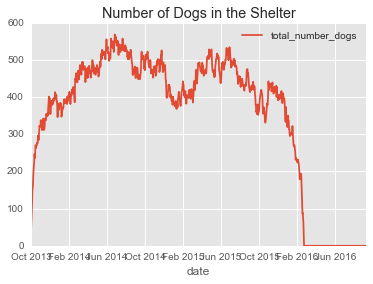

In [54]:
capacity_df.plot(x="date", title="Number of Dogs in the Shelter")

In [55]:
# add the count of the total number of dogs to the dataframe of dog intake/outcomes.  the variable will be the 
# total number of dogs in the shelter on the day that the particular dog entered
joined = pd.merge(joined, capacity_df, left_on="in_date",right_on="date", how="left")
joined.drop("date", axis=1, inplace=True)

In [56]:
# further data cleaning
# drop unnecessary columns
keeps = [u'ID', u'in_date', u'out_date', u'Name_x',
       u'Found Location', u'Intake Type', u'Intake Condition',
       u'Sex upon Intake', u'Age upon Intake', u'Breed_x',
       u'Color_x', u'Name_y', u'Outcome Type',
       u'Outcome Subtype', u'Sex upon Outcome', u'total_number_dogs']
merged = joined[keeps]

In [57]:
# rename columns 
merged.columns = [u'ID', u'in_date', u'out_date', u'in_name', u'location',
       u'in_type', u'in_condition', u'in_sex',
       u'in_age', u'in_breed', u'in_colour', u'out_name', u'outcome',
       u'outcome_sub', u'out_sex', u'total_number_dogs']

In [58]:
# subset to data where outcome is available
merged["in_date"] = merged.loc[:,"in_date"].apply(lambda x: pd.to_datetime(x).date())
merged["out_date"] = merged.loc[:,"out_date"].apply(lambda x: pd.to_datetime(x).date())
merged = merged[~pd.isnull(merged["out_date"])]

/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [59]:
# subset data to intakes from 2014/15 only. since outcomes data continues into february, this should avoid most
# censorship if we only consider dogs who have recorded outcomes
start_date = pd.to_datetime("1/1/2014").date()
end_date = pd.to_datetime("12/31/2015").date()
merged = merged[(merged["in_date"]>=start_date)&(merged["in_date"]<=end_date)]

In [60]:
# create column for number of days a dog is in a shelter
merged["shelter_time"] = merged.loc[:,"out_date"] - merged.loc[:,"in_date"]
merged["shelter_time"] = merged.loc[:,"shelter_time"].apply(lambda x: x / np.timedelta64(1, 'D')).astype(int)
# remove any records for which shelter time is <0 -- these are obviously incorrect
merged = merged[~merged["shelter_time"]<0]

In [61]:
with open('merge1.pkl', 'w') as picklefile:
    pickle.dump(merged, picklefile)

In [62]:
# split sex column into sex and neuter/spay
# split sex into sex and neuter
def split_sex(x,index):
    try:
        return x.split(" ")[index]
    except:
        return np.nan

merged["in_neuter"] = merged["in_sex"].apply(lambda x: split_sex(x,0))
merged["in_sex"] = merged["in_sex"].apply(lambda x: split_sex(x,1))
merged["out_neuter"] = merged["out_sex"].apply(lambda x: split_sex(x,0))

def neuter(x):
    if x =="Neutered" or x=="Spayed":
        return 1
    elif x == "Intact":
        return 0
    else:
        return x
    
merged["in_neuter"] = merged["in_neuter"].apply(neuter)
merged["out_neuter"] = merged["out_neuter"].apply(neuter)

In [63]:
# convert age to float of number of years old
def age_in_years(x):
    age = x.split(" ")
    if age[1] in ["week","weeks"]:
        return int(age[0])/52
    elif age[1] in ["month","months"]:
        return int(age[0])/12
    else:
        return int(age[0])

merged["in_age"] = merged["in_age"].apply(age_in_years)


For each dog, a string describing colouring is provided. There is little consistency in the naming, as can be seen from the excerpt below. To create consitency, all the descriptions are bucketed into: dark mix, dark, light mix, light, medium and medium mix.

In [64]:
merged.loc[:,"in_colour"].values[:10]

array(['White', 'Sable/White', 'Black Brindle/White', 'Tan', 'Tan',
       'White/Brown', 'Black/Brown', 'Blue Merle/White',
       'Black Brindle/White', 'Brown/White'], dtype=object)

In [65]:
# create a list of all unique colours that appear in descriptions
all_colours = []
for i in merged["in_colour"]:
    try:
        x = i.split("/")
        try:
            for j in x:
                a = j.split(" ")
                for b in a:
                    all_colours.append(b)
        except:
            for j in x:
                all_colours.append(j)
    except:
        all_colours.append(i)
        
all_colours = list(set(all_colours))
print all_colours

['Blue', 'Pink', 'Black', 'Sable', 'Orange', 'White', 'Red', 'Buff', 'Brown', 'Merle', 'Chocolate', 'Tiger', 'Liver', 'Tick', 'Silver', 'Gray', 'Apricot', 'Tabby', 'Ruddy', 'Smoke', 'Fawn', 'Gold', 'Tricolor', 'Yellow', 'Brindle', 'Tan', 'Cream']


In [66]:
# create mapping of words to dark colours, medium colours, light colours, and mix
med_col = ['Blue', 'Orange', 'Red', 'Silver', 'Gray', 'Apricot', 'Gold']
light_col = ['Pink', 'Sable', 'White', 'Buff', 'Fawn', 'Yellow', 'Tan', 'Cream']
dark_col = ['Black', 'Brown', 'Chocolate', 'Liver']
mix_col = ['Merle', 'Tick', 'Tabby', 'Ruddy', 'Smoke', 'Tricolor', 'Tiger', 'Brindle']

In [67]:
# create colour mappings: if colour description has two or more colours, or contains a mix word (e.g. brindle),
# dog is deemed to have mixed colouring.  if any of the colours in the description are dark colours, dog is deemed 
# to be dark mix.  if any of the colour decriptions are medium, dog is deemed to be medium mix.  otherwise dog is deemed
# to be light mix.  process repeated for non mixed colouring.
def colour_chart(x):
    colour_list = []
    for i in x.split("/"):
        for j in i.split(" "):
            colour_list.append(j)
    if len(colour_list)>1 or any(x in colour_list for x in mix_col):
        if any(x in colour_list for x in dark_col):
            return "dark mix"
        elif any(x in colour_list for x in med_col):
            return "medium mix"
        else:
            return "light mix"
    else:
        if any(x in colour_list for x in dark_col):
            return "dark"
        elif any(x in colour_list for x in med_col):
            return "medium"
        else:
            return "light"

In [68]:
merged["colour"] = merged["in_colour"].apply(colour_chart)
merged["colour"].value_counts()

dark mix      9642
light mix     3321
light         2961
dark          2089
medium mix    2010
medium         722
Name: colour, dtype: int64

The breed descriptions for each dog may contain multiple breeds, or a single breed, or a single listed breed but the dog is noted to be mixed breed (excerpt shown below). To make this more internally consistent, a list of composite breeds is created for each dog. The goal of this is to be able to
- 1) mark each dog as a member of specific breeds
- 2) to match each dog to breed characteristics (like size, energy level etc), and to breed group (working / toy etc). - In order achieve the second, information was scraped for all listed breeds on the American Kennel Club (AKC) website.

In [69]:
list(merged["in_breed"][:10])

['Great Pyrenees Mix',
 'Siberian Husky Mix',
 'Pit Bull',
 'Pit Bull Mix',
 'Chihuahua Shorthair Mix',
 'Great Pyrenees Mix',
 'Labrador Retriever Mix',
 'Catahoula Mix',
 'American Pit Bull Terrier Mix',
 'Pit Bull/Labrador Retriever']

In [70]:
# create flag for mixed breed dog - either if more than one breed listed, or the word "mix" is included
def breed_mix(x):
    if "Mix" in x:
        return 1
    elif "/" in x:
        return 1
    else:
        return 0
merged["mix"] = merged["in_breed"].apply(breed_mix)

In [71]:
# split the breed into list of composite breeds
def breed_parse(x):
    x = x.replace("Mix","").strip()
    try:
        return x.split("/")
    except:
        return x
merged["breed_list"] = merged["in_breed"].apply(breed_parse)

def breed_lower(x):
    breed_list = []
    for i in x:
        breed_list.append(i.lower())
    return breed_list

merged["breed_list"] = merged["breed_list"].apply(breed_lower)

In [72]:
# some breeds may be misspelled in shelter dataset, so find the closest match to each breed in akc table, and correct 
# the name
def correct_names(x):
    breed_list=[]
    for i in x:
        try:
            breed_list.append(get_close_matches(i, akc_table["breed"], n=1,cutoff=0.6)[0])
        except:
            breed_list.append(np.nan)
    return breed_list

merged["breed_list_corrected"] = merged["breed_list"].apply(correct_names)

In [76]:
# create df of breeds and find which are not in AKC database
breeds = []
for i in merged['breed_list']:
    for j in i:
        breeds.append(j)

correct_breeds = []
for i in merged['breed_list_corrected']:
    for j in i:
        correct_breeds.append(j)
breed_df = pd.DataFrame(zip(breeds,correct_breeds),columns=["breed","corrected"])
print breed_df[pd.isnull(breed_df["corrected"])]["breed"].value_counts()

# add info for top 4 most common missing breeds (pb, catahoula, black mouth cur, blue lacy, queensland heeler).  
#information gathered from wikipedia
#pit bull
add_list = pd.DataFrame([np.nan,"pit bull",np.nan,3,2,1,1,3]).T
add_list.columns = akc_table.columns
akc_table = pd.concat([akc_table,add_list], axis=0)
#catahoula
add_list = pd.DataFrame([np.nan,"catahoula",np.nan,3,2,1,1,3]).T
add_list.columns = akc_table.columns
akc_table = pd.concat([akc_table,add_list], axis=0)
#black mouth cur
add_list = pd.DataFrame([np.nan,"black mouth cur",np.nan,3,3,1,1,3]).T
add_list.columns = akc_table.columns
akc_table = pd.concat([akc_table,add_list], axis=0)
#blue lacy
add_list = pd.DataFrame([np.nan,"blue lacy",np.nan,3,3,1,1,3]).T
add_list.columns = akc_table.columns
akc_table = pd.concat([akc_table,add_list], axis=0)
#queensland heeler
add_list = pd.DataFrame([np.nan,"queensland heeler",np.nan,3,2,1,1,3]).T
add_list.columns = akc_table.columns
akc_table = pd.concat([akc_table,add_list], axis=0)

# with updated table, redo algorithm to correct name spellings in shelter df
def correct_names(x):
    breed_list=[]
    for i in x:
        try:
            breed_list.append(get_close_matches(i, akc_table["breed"], n=1,cutoff=0.6)[0])
        except:
            breed_list.append(np.nan)
    return breed_list

merged["breed_list_corrected"] = merged["breed_list"].apply(correct_names)

# map breeds to AKC groups.  if any one of a dog's listed breeds is in a particular breed group, the dog is deemed
# a member of the group
def group_list(x):
    group_list = []
    for i in x:
        try:
            group_list.append(list(akc_table[akc_table["breed"]==i]["group"])[0])
        except:
            group_list.append(np.nan)
    return group_list

merged["group_list"] = merged["breed_list_corrected"].apply(group_list)

black            33
pbgv             20
feist            11
treeing cur       9
presa canario     7
landseer          5
jindo             4
cirneco           1
unknown           1
Name: breed, dtype: int64


In [77]:
# check which AKC groups are represented in the data
breed_groups = []
for i in merged['group_list']:
    for j in i:
        breed_groups.append(j)
breed_groups = list(set(breed_groups))
print breed_groups

[nan, 'miscellaneous-class', 'herding', 'toy', 'working', 'sporting', 'non-sporting', 'hound', 'terrier']


In [78]:
# replace na with "other" for any dogs whose breeds are not AKC recognized breeds
breed_groups[0]="other"

# create columns for dummies
for col in breed_groups:
    merged[col]=""

# function to create dummies
def group_dummies(x,group):
    if group in x:
        return 1
    else:
        return 0
for group in breed_groups:
    merged[group] = merged["group_list"].apply(lambda x: group_dummies(x,group))
    
# if any group is na, mark 1 in "other" group column
def other_group(x):
    if np.nan in x:
        return 1
    else:
        return 0
    
merged["other"] = merged["group_list"].apply(other_group)

In [80]:
# create coat, groom, exercise metrics for each dog (average for the listed breeds for each dog)
def score(x,col):
    temp_list = []
    for breed in x:
        try:
            temp_list.append(list(akc_table[col][akc_table["breed"]==breed])[0])
        except:
            temp_list.append(np.nan)
    return np.nanmean(temp_list)

for var in ["energy","size","coat","groom","exercise"]:
    merged[var] = merged["breed_list_corrected"].apply(lambda x: score(x,var))

In [81]:
merged.head()

,ID,in_date,out_date,in_name,location,in_type,in_condition,in_sex,in_age,in_breed,...,working,sporting,non-sporting,hound,terrier,energy,size,coat,groom,exercise
2634,A605191,2014-01-01,2014-01-05,Paloma,650 Bastrop Hwy in Austin (TX),Stray,Normal,Female,3.000000,Great Pyrenees Mix,...,1,0,0,0,0,2.0,3.0,2.0,1.0,3.0
2635,A636714,2014-01-01,2014-01-05,Blue,12034 Research in Austin (TX),Stray,Normal,Male,4.000000,Siberian Husky Mix,...,1,0,0,0,0,3.0,2.0,2.0,1.0,3.0
2636,A664578,2014-01-01,2014-01-03,Rufus,Austin (TX),Owner Surrender,Normal,Male,4.000000,Pit Bull,...,0,0,0,0,0,3.0,2.0,1.0,1.0,3.0
2637,A668372,2014-01-01,2014-01-12,*Greta,Austin (TX),Owner Surrender,Normal,Female,0.916667,Pit Bull Mix,...,0,0,0,0,0,3.0,2.0,1.0,1.0,3.0
2638,A668374,2014-01-01,2014-01-03,Princessa,Austin (TX),Owner Surrender,Normal,Female,0.416667,Chihuahua Shorthair Mix,...,0,0,0,0,0,2.0,1.0,1.0,1.0,2.0


In [82]:
with open('merge2.pkl', 'w') as picklefile:
    pickle.dump(merged, picklefile)

In [83]:
# create a list of all breeds represented in the data
all_breeds = []
for dog in merged["breed_list_corrected"]:
    for breed in dog:
        all_breeds.append(breed)

In [92]:
all_breeds = list(set(all_breeds))
len(all_breeds)
all_breeds.remove(np.nan)

In [93]:
# create breed dummies - for each dog, for every breed listed, the dog is included as a member of that breed 

# create columns for dummies
for col in all_breeds:
    merged[col]=""

# function to create dummies
def breed_dummies(x,breed):
    if breed in x:
        return 1
    else:
        return 0
for breed in all_breeds:
    merged[breed] = merged["breed_list_corrected"].apply(lambda x: breed_dummies(x,breed))

In [94]:
# mark aggressive breeds
aggressive = ["pit bull","american staffordshire terrier","staffordshire bull terrier"]
merged["aggressive"] = merged["breed_list_corrected"].apply(lambda x: int(any(i in aggressive for i in x)))

In [99]:
# check for missingness on data
np.sum(merged.isnull()).sort_values(ascending=False).head(10)

outcome_sub               14026
out_name                   3167
in_name                    3130
in_sex                      103
energy                       49
size                         49
coat                         49
groom                        49
exercise                     49
miniature bull terrier        0
dtype: int64

### Exploring the Name
In order to characterize the dog's name, and examine the effect it might have on the dog's outcome, three sets of features will be created.
- 1) Is it a popular dog name?
- 2) Is it a popular human name? This will also be measured by decade
- 3) Is the name an English word?

In [100]:
# remove asterisks from names
def split_name(x):
    if type(x)==float:
        return 0
    elif "*" not in x:
        return 0
    else:
        return 1
merged["in_name_mark"] = merged["in_name"].apply(split_name)
merged["out_name_mark"] = merged["in_name"].apply(split_name)

def short_name(x):
    try:
        return x.replace("*","")
    except:
        return x
merged["in_name"] = merged["in_name"].apply(short_name)
merged["out_name"] = merged["out_name"].apply(short_name)

In [101]:
#explore missing values
print len(merged[~pd.isnull(merged["in_name"])&pd.isnull(merged["out_name"])]), "missing on outcome but not intake"
print len(merged[pd.isnull(merged["in_name"])&~pd.isnull(merged["out_name"])]), "missing on intake but not outcome"

print \
sum(merged[(~pd.isnull(merged["in_name"]))&(~pd.isnull(merged["out_name"]))]["in_name"]\
!=merged[(~pd.isnull(merged["in_name"]))&(~pd.isnull(merged["out_name"]))]["out_name"]),\
"intake and outcome names don't match"

37 missing on outcome but not intake
0 missing on intake but not outcome
136 intake and outcome names don't match


In [102]:
# try to use outcome, if missing, use intake, if missing, leave missing
def correct_name(row):
    if pd.isnull(row["out_name"])==False:
        return row["out_name"]
    elif pd.isnull(row["in_name"])==False:
        return row["in_name"]
    else:
        return np.nan

In [103]:
merged["name"] = merged.apply(correct_name, axis=1)

In [104]:
# check for missingness on data
np.sum(merged.isnull()).sort_values(ascending=False).head(10)

outcome_sub    14026
out_name        3167
in_name         3130
name            3130
in_sex           103
energy            49
size              49
coat              49
groom             49
exercise          49
dtype: int64

In [105]:
# make all names lowercase
merged["name"] = merged["name"].apply(lambda x: x.lower() if type(x)==str else x)

In [106]:
# add flag for missing name
merged["missing_name"] = merged["name"].apply(lambda x: 1 if pd.isnull(x) else 0)

In [107]:
# create a flag if the name is cute (ends in y, i, ee, ie, ey)
def cute_name(x):
    try:
        if x[-2:] =="ee" or x[-2:] =="ie" or x[-2:] =="ey" or x[-1]=="y"or x[-1]=="i":
            return 1
        else:
            return 0
    except:
        return 0

merged["cute_name"] = merged["name"].apply(cute_name)

In [108]:
with open('merge3.pkl', 'w') as picklefile:
    pickle.dump(merged, picklefile)

In [113]:
# from selenium import webdriver

# driver = webdriver.PhantomJS(executable_path='/Users/pt/Downloads/phantomjs-2.1.1-macosx/bin/phantomjs')
# for i in range(1,117):
#     full_path = "https://www.petfinder.com/pet-search?query_id=CBCB4798-75D0-11E6-BFC6-D874A9284BC8&page_number={}".format(i)
#     driver.get(full_path)
#     print i
#     soup = BeautifulSoup(driver.page_source, "lxml")
#     for div in soup.find_all("div", class_="pet-name-container"):
#         name_list.append(div.text.strip())


In [114]:
with open('petfinder.pkl', 'w') as picklefile:
    pickle.dump(name_list, picklefile)

In [6]:
def split_name(x):
    try:
        return  x.split(" in")[0].lower()
    except:
        return x.lower()

def remove_numbers(x):
    return ''.join([i for i in x if not i.isdigit()])
    
petfinder_names = [split_name(i) for i in name_list]
petfinder_names = [remove_numbers(i) for i in petfinder_names]
petfinder_names = [x.replace("referral","") for x in petfinder_names]

In [13]:
from collections import Counter
name_counts = Counter
petfinder_df = pd.DataFrame.from_dict(Counter(petfinder_names), orient='index').sort_values(0,ascending=False)
petfinder_df.columns = ["freq"]
petfinder_df["freq"] = petfinder_df["freq"].apply(lambda x: x/len(petfinder_names))
top_dog_names = list(petfinder_df[petfinder_df["freq"]>0.002].index)
top_dog_names.pop(0)
merged["popular_dog_name"] = merged["name"].apply(lambda x: x in top_dog_names)

/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [14]:
# compare the dogs name to other dogs in the same shelter.  If its name is in the top 0.2% of names in the shelter,
# it is deemed to have a common name in that shelter
name_counts = merged["name"].value_counts(dropna=False).to_frame()
name_counts.columns = ["freq"]
name_counts["freq"] = name_counts["freq"].apply(lambda x: x/len(merged))
name_counts.drop(name_counts.index[0], inplace=True)
top_dog_names_shelter = list(name_counts[name_counts["freq"]>0.002].index)
merged["popular_shelter_name"] = merged["name"].apply(lambda x: x in top_dog_names_shelter)

In [16]:
#convert booleans to ints
merged["popular_dog_name"] = merged["popular_dog_name"].apply(lambda x: int(x))
merged["popular_shelter_name"] = merged["popular_shelter_name"].apply(lambda x: int(x))

In [17]:
# to compare dog names to human names, use SSA data
names = pd.read_csv("data/NationalNames.csv")
names["Name"] = names["Name"].apply(lambda x: x.lower())

# divide data into decades
names["decade"] = names["Year"].apply(lambda x: x - x%10)

In [18]:
# create dataframes for men / women by decade
by_decade_men = pd.pivot_table(names[names["Gender"]=="M"],index="Name",columns="decade",values="Count",aggfunc=np.sum)
by_decade_men.fillna(0,inplace=True)

by_decade_women = pd.pivot_table(names[names["Gender"]=="F"],index="Name",columns="decade",values="Count",aggfunc=np.sum)
by_decade_women.fillna(0,inplace=True)

In [19]:
decades = list(set(names["decade"]))
# convert to %
for i in decades:
    dec_sum = sum(by_decade_men[i])
    by_decade_men[i] = by_decade_men[i].apply(lambda x: x/dec_sum)
for i in decades:
    dec_sum = sum(by_decade_women[i])
    by_decade_women[i] = by_decade_women[i].apply(lambda x: x/dec_sum)

In [20]:
by_decade_men.to_csv("data/men_names.csv")
by_decade_women.to_csv("data/women_names.csv")

In [21]:
# create top names by decade - any name over 0.25% for that decade
names_dict={}
sexes = ["F","M"]
for i in decades:
    for sex in sexes:
        var_name = sex+str(i)
        if sex =="F":
            names_dict[var_name] = list(by_decade_women[by_decade_women[i]>0.0025].index)
        else:
            names_dict[var_name] = list(by_decade_men[by_decade_men[i]>0.0025].index)

In [22]:
# create colum names for df
decade_cols = []
for i, j in names_dict.iteritems():
    decade_cols.append(i)
    
# create empty cols for era binaries
for i in decade_cols:
    merged[i] = ""
    
def name_type(row,col):
    if row["name"] in names_dict[col]:
        return 1
    else:
        return 0
# mark decade cols       
for decade in decade_cols:
    merged[decade] = merged.apply(lambda x: name_type(x,decade), axis=1)

In [23]:
# check if the name appears in SSA list at all (i.e. is it a human name, however popular)
all_names = list(set(names["Name"]))
merged["human_name"] = merged["name"].apply(lambda x: 1 if x in all_names else 0)

In [24]:
merged["month_in"] = merged["in_date"].apply(lambda x: x.month)

In [38]:
word_list = set(words.words())
merged["word_name"] = merged["name"].apply(lambda x: x in word_list)
merged["word_name"] = merged["word_name"].apply(lambda x: int(x))

In [42]:
with open('merge4.pkl', 'w') as picklefile:
    pickle.dump(merged, picklefile)

In [43]:
# drop columns that aren't needed
drops = ['in_name', 'location','in_breed', 'in_colour',
       'out_name', 'out_sex',
       'out_neuter',
       'breed_list', 'group_list',
        'in_name_mark', 'out_name_mark']
sub = merged.drop(drops,axis=1)

In [45]:
# check for missingness
np.sum(sub.isnull()).sort_values(ascending=False).head()

outcome_sub    14026
name            3130
in_sex           103
energy            49
coat              49
dtype: int64

In [46]:
# impute missing energy, size, coat, exercise and grooming by updating with mean values
mean_energy = sub["energy"].mean()
mean_size = sub["size"].mean()
mean_coat = sub["coat"].mean()
mean_exercise = sub["exercise"].mean()
mean_groom = sub["groom"].mean()

sub["energy"] = sub["energy"].fillna(mean_energy)
sub["size"] = sub["size"].fillna(mean_size)
sub["coat"] = sub["coat"].fillna(mean_coat)
sub["exercise"] = sub["exercise"].fillna(mean_exercise)
sub["groom"] = sub["groom"].fillna(mean_groom)

In [47]:
# check for missingness
np.sum(sub.isnull()).sort_values(ascending=False).head()

outcome_sub             14026
name                     3130
in_sex                    103
word_name                   0
pembroke welsh corgi        0
dtype: int64

In [48]:
# impute missing sex by using the mode.  
print sub["in_sex"].value_counts()
#impute missing sex as male
sub["in_sex"] = sub["in_sex"].fillna("Male")

Male      11104
Female     9538
Name: in_sex, dtype: int64


In [49]:
# convert sex to numeric
sub["in_sex"] = sub["in_sex"].apply(lambda x: 1 if x=="Male" else 0)

In [50]:
with open('sub.pkl', 'w') as picklefile:
    pickle.dump(sub, picklefile)

In [66]:
print top_dog_names

[u'cookie', u'blue', u'daisy', u'bella', u'rocky', u'jackson', u'king', u'duke', u'roscoe', u'lucy', u'chico', u'fiona', u'princess', u'lola', u'monty', u'morgan', u'bailey', u'molly', u'luke', u'jack', u'raven', u'max', u'junior', u'sadie', u'reese', u'libby', u'oreo', u'oliver', u'honey', u'brownie', u'wally', u'rusty', u'tulip', u'cane', u'hercules', u'lady', u'diesel', u'maggie', u'izzy', u'colt', u'earl', u'penny', u'murphy', u'bentley', u'lulu', u'sky', u'zoey', u'cooper', u'jazz', u'caleb', u'snowy', u'ellie', u'lily', u'star', u'rosie', u'goldie']


In [67]:
print top_dog_names_shelter

['bella', 'max', 'daisy', 'charlie', 'rocky', 'princess', 'buddy', 'lucy', 'lucky', 'luna', 'coco', 'chico', 'lola', 'sadie', 'jack', 'lady', 'blue', 'molly', 'duke', 'toby', 'bear', 'diamond', 'sasha', 'shadow', 'chloe', 'rosie', 'brownie', 'zeus', 'oso', 'lily', 'ginger', 'rex', 'marley', 'oreo', 'king', 'cookie', 'buster', 'maggie', 'ruby', 'roxy']
